In [1]:
#setup imports and make ure the files we care about exist
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
from pprint import pprint

#custom modules
import feature_extraction
import unsw_nb15_dataset
import networks

from importlib import reload #allow us to reload custom modules any time we like with modifications
reload(feature_extraction)
reload(unsw_nb15_dataset)
reload(networks)

<module 'networks' from '/home/jaywalker/MachineLearning/PacketGAN/networks.py'>

In [2]:
#set up the dataset(s)

#set some hyperparameters
sequence_length=25
batch_size=64 #always using size 1 because I can't seem to make the GRU work correctly with larger batches

#first, load the dataset
data_set_original = unsw_nb15_dataset.UNSW_NB15('UNSW_NB15_full_clean.csv',
                                       sequence_length=sequence_length, 
                                       transform=feature_extraction.build_feature_sequence_tensor)

#pick out the attack examples
data_set_original.use_only_category('DoS'); #in this case just look at DoS attack samples 

#get rid of this when you want to use the whole set
fraction_to_use = 1
data_set, _ = random_split(data_set_original, [round(len(data_set_original) * fraction_to_use), len(data_set_original) - round(len(data_set_original) * fraction_to_use)])

train_set_length = round(len(data_set) * 0.8)
test_set_length = len(data_set) - train_set_length
train_set, test_set = random_split(data_set, [train_set_length, test_set_length])

data_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=1)

data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Network input data shape: ", data_example.shape)
print("Number of training examples: ", len(data_loader.dataset))

/home/jaywalker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Network input data shape:  torch.Size([64, 25, 137])
Number of training examples:  13062


Number of input features:  137
Latent dimensions:  25


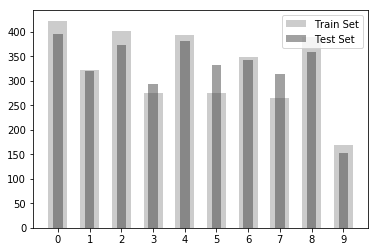

In [3]:
#train a KMeans classifier for cluster evaluation
import evaluation
reload(evaluation)

num_features = data_set[0].shape[1]
print("Number of input features: ", num_features)
latent_dimensions = 25
print("Latent dimensions: ", latent_dimensions)

latent_space_mapper = networks.GRUMapping(num_features, latent_dimensions, batch_size)

#convert the train_set and test_set to a lower dimensional space for clustering
train_set_latent = []
train_comparison_set, _ = random_split(train_set, [len(test_set), len(train_set) - len(test_set)])
train_comparison_set_dl = DataLoader(train_comparison_set, batch_size=batch_size, shuffle=True) #use a dataloader so the examples are batched
with torch.no_grad():
    for example in train_comparison_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network so we don't have to deal with too many technicalities...
            #maybe we could deal with that by changing the size of the hidden state of the network before inputting the data?
        train_set_latent.extend(latent_space_mapper(example).numpy()[0])
        
#print(train_set_latent)

test_set_latent = []
test_set_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True)
with torch.no_grad():
    for example in test_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network to keep things easy
        test_set_latent.extend(latent_space_mapper(example).numpy()[0])

#print("Latent test set length: ", len(test_set_latent))
#pprint(test_set_latent)
#print("Latent test set element size: ", test_set_latent[0].shape)
kmeans = evaluation.KMeansTorch(n_clusters=10)
kmeans.fit(train_set_latent)

#are the train set and test set from the same distribution?
train_counts, test_counts = evaluation.cluster_and_compare(kmeans, train_set_latent, test_set_latent, retrain=False)

In [4]:
#define the networks 
G = networks.Generator(sequence_length, data_example.shape[2], data_example.shape[2] * 3, 30, data_example.shape[2], batch_size, torch.sigmoid, noise_input=True)
D = networks.Discriminator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 1, batch_size, torch.sigmoid)

Training: [##############################] 99.5%
Epoch:  200 / 200
D Real Error:  0.0019512176513671875
D Fake Error:  0.0019512176513671875
G Error:  -0.8575369119644165
Remaining time: 0:05:56.405830


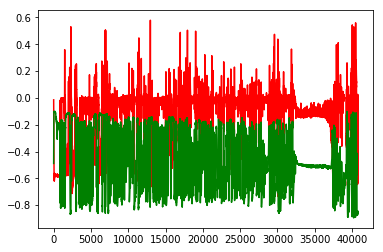

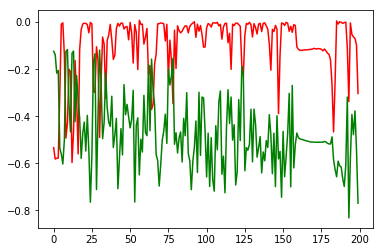

In [5]:
#train GAN to replace masked packets
#by iterating over the dataset for some # of epochs

import train
reload(train)
reload(networks)

#Train the network!
num_epochs = 200
G, D, g_losses, df_losses, g_stats, df_stats = train.train_gan(G,D,data_loader,num_epochs)

#plot instantaneous losses
plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
plt.show()

#plot loss averages
plt.plot(range(len(df_stats.get_averages())), df_stats.get_averages(), 'r-', range(len(g_stats.get_averages())), g_stats.get_averages(), 'g-')
plt.show()

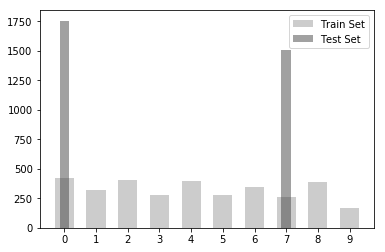

In [6]:
#cluster and compare. Are the fake examples even remotely matching the original distribution?
#first generate a set of masked sequences
gan_latent_test_set = []
with torch.no_grad():
    for example in test_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network to keep things easy
        generated_example = G(example)
        gan_latent_test_set.extend(latent_space_mapper(generated_example).numpy()[0])

#then compare the native GAN output
train_counts, test_counts = evaluation.cluster_and_compare(kmeans, train_set_latent, gan_latent_test_set, retrain=False)

In [7]:
#This is a test of the wasserstein critic/approximate wasserstein distance
import torch.utils.data
import evaluation
reload(evaluation)

real_set, generator_input, _ = random_split(test_set, [len(test_set) // 2, len(test_set) // 2, len(test_set) - 2*(len(test_set) // 2)]) #I'm assuming it's got at least 200 examples to spare
real_set_df = DataLoader(real_set, batch_size=batch_size)
generator_input_df = DataLoader(generator_input, batch_size=batch_size)
#print("Len real_set_df: ", len(real_set_df))
#print("Len generator_input_df", len(generator_input_df))
real_list = []
#assuming real_train_set and real_test_set are equal length
for e in real_set_df:
    if e.shape[0] != batch_size:
        continue
    real_list.append(e)

fake_list = []
for e in generator_input_df:
    if e.shape[0] != batch_size:
        continue
    with torch.no_grad():
        fake_list.append(G(e)) #G ouput already has batch dimension

#print("Real set length: ", len(real_list))
#print("Fake set length: ", len(fake_list))
#print(real_list[0].shape)
#print(fake_list[0].shape)

w_hat, accuracy = evaluation.wasserstein_critic(real_list, fake_list)
print("Wasserstein Distance: ", w_hat)
print("Classification Accuracy: ", accuracy)


Wasserstein Distance:  0.7118533646729801
Classification Accuracy:  0.9212007504690432


In [12]:
def print_dict_compare(dict1, dict2):
    for k in dict1:
        if k not in dict2:
            return None
        
    for k in dict1:
        print(dict1[k], "\t\t", dict2[k])

def dict_list_compare(dict_list1, dict_list2):
    for l in range(0, len(dict_list1)):
        print_dict_compare(dict_list1[l], dict_list2[l])
    print("\n\n")

            
import random
data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Real data\tFake data")
real_data = feature_extraction.decode_feature_sequence_tensor(data_set_original, data_example[0])

#note herethat "gen" is the trained generator returned from the training function above
generated_data = G(data_example).detach()
fake_data = feature_extraction.decode_feature_sequence_tensor(data_set_original, generated_data[0])

dict_list_compare(real_data, fake_data)

#print("From data set:")
#print(feature_extraction.decode_feature_sequence_tensor(data_set, data_set[0]))

Real data	Fake data
175.45.176.1 		 175.45.176.2
149.171.126.17 		 149.171.126.31
0 		 0
0 		 0
vmtp 		 ospf
INT 		 INT
8.999999643670854e-06 		 0.7639904116239502
200 		 3050
0 		 4119
254 		 209
0 		 45
0 		 1
0 		 1
88888889.28333855 		 139275683.8066702
0.0 		 1295.6512294589775
2 		 9
0 		 4
0 		 25
0 		 35
0 		 0
0 		 0
100 		 537
0 		 4
0 		 0
0 		 178
0.0 		 166.57708367694758
0.0 		 16.150249630673002
1424244410 		 1397441089
1424244411 		 1424077852
0.008999999870855731 		 130.72809680270032
0.0 		 3.094263020379294
0.0 		 0.0028141884340608376
0.0 		 0.0013788969642003067
0.0 		 0.0019308259422751723
175.45.176.1 		 175.45.176.2
149.171.126.17 		 149.171.126.27
0 		 0
0 		 0
vmtp 		 ospf
INT 		 INT
8.999999643670854e-06 		 0.8588805560545933
200 		 2945
0 		 3695
254 		 211
0 		 33
0 		 1
0 		 1
88888889.28333855 		 146453107.53108883
0.0 		 1275.8355733971111
2 		 10
0 		 4
0 		 19
0 		 27
0 		 0
0 		 0
100 		 498
0 		 4
0 		 0
0 		 183
0.0 		 142.9283699580747
0.0 		 14.84

266666645.54297638 		 177346616.95832348
0.0 		 1476.679768800299
2 		 10
0 		 4
0 		 21
0 		 28
0 		 0
0 		 0
100 		 430
0 		 6
0 		 0
0 		 217
0.0 		 213.82120982672387
0.0 		 18.32745966499392
1424244410 		 1404701192
1424244411 		 1424090925
0.003000000056867833 		 113.6621767722331
0.0 		 3.6869038834047387
0.0 		 0.0034977983360474467
0.0 		 0.001960294403728796
0.0 		 0.0021253279475657036
175.45.176.1 		 175.45.176.2
149.171.126.17 		 149.171.126.27
0 		 0
0 		 0
wb-expak 		 ospf
INT 		 INT
4.999999856234516e-06 		 0.8877214562752628
200 		 3355
0 		 4521
254 		 209
0 		 35
0 		 1
0 		 1
160000005.17141724 		 141764134.41789627
0.0 		 1248.366423491767
2 		 10
0 		 4
0 		 23
0 		 29
0 		 0
0 		 0
100 		 447
0 		 5
0 		 0
0 		 175
0.0 		 201.08111157665192
0.0 		 16.17110186797607
1424244410 		 1398836215
1424244411 		 1424111809
0.004999999894947877 		 119.28087008600681
0.0 		 3.080199205578247
0.0 		 0.0027429470141030615
0.0 		 0.0018048833160011564
0.0 		 0.0019707920286310